This notebook is used for comparison of how much similarity is preserved by each method

We will use cosine similarity of our initial dataset as as ground truth

In [1]:
# test size
N = 100000
num_bits = 512

In [2]:
from random import sample
from time import time
from pickle import dump, load


from IPython.display import clear_output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_similarity_score
from datasketch import WeightedMinHash, WeightedMinHashGenerator
from scipy.stats import describe

In [3]:
df = pd.read_csv('./dataset.csv', index_col=0)
df_h = pd.read_csv('./neural_hashes.csv', index_col=0)
with open('./sims.pkl', 'rb') as f:
    sims_train_set = load(f)

In [4]:
# test on data that has not been used during training
training_pairs = set()
for movie_name in sims_train_set:
    for pair_type in sims_train_set[movie_name]:
        for movie_subname in sims_train_set[movie_name][pair_type]:
            # for sake of bidirectionality
            training_pairs.add((movie_name, movie_subname))
            training_pairs.add((movie_subname, movie_name))

In [5]:
# generate combinations of movie titles for testing
titles = set(df.index.values)

# genrate weighted minhash gen
wmg = WeightedMinHashGenerator(len(df.columns), sample_size=num_bits)

In [6]:
# generate random, shuffled combinations (can't use itertools.combinations for this)
combs = set()
while len(combs) < N:
    pair = tuple(sample(titles, 2))
    if pair not in training_pairs:
        combs.add(pair)

In [7]:
# get similarity score for each representation
gt_cos_arr = np.zeros((N,))
jacc_minhash_arr = np.zeros((N,))
nh_jacc_arr = np.zeros((N,))

start = time()
for i, comb in enumerate(combs):        
    title_x, title_y = comb
    arr_x = df.loc[title_x].values
    arr_y = df.loc[title_y].values
    
    # ground truth
    gt_cos_arr[i] = cosine_similarity(arr_x.reshape(1, -1), arr_y.reshape(1, -1))[0][0]
    
    # minhash from datasketch
    m_x = wmg.minhash(arr_x)
    m_y = wmg.minhash(arr_y)
    jacc_minhash_arr[i] = m_x.jaccard(m_y)
    
    # neural hashes
    hash_x = df_h.loc[title_x].values
    hash_y = df_h.loc[title_y].values
    
    nh_jacc_arr[i] = jaccard_similarity_score(hash_x.reshape(1, -1), hash_y.reshape(1, -1))
    
    if i % 100 == 0:
        clear_output()
        print(f'Completed {i}/{N} samples.')
    
print(f'Computing similarity took {time() - start} seconds.')

Completed 99900/100000 samples.
Computing similarity took 8611.198449850082 seconds.


In [20]:
result = ''

diff_hash_jacc = gt_cos_arr - nh_jacc_arr
mae_hash_jacc = (np.abs(diff_hash_jacc)).mean()
result += f'MAE for neural hashes using jaccard is: {mae_hash_jacc}' + '\n'
result += 'Diff result: ' + str(describe(diff_hash_jacc)) + 2 * '\n'

diff_minhash = gt_cos_arr - jacc_minhash_arr
mae_minhash = (np.abs(diff_minhash)).mean()
result += f'MAE for WeightedMinhash from Datasketch is: {mae_minhash}'
result += 'Diff result: ' + str(describe(diff_minhash)) + 2 * '\n'
print(result)


MAE for neural hashes using jaccard is: 0.11835930458700708
Diff result: DescribeResult(nobs=100000, minmax=(-0.4717179210778858, 0.5615603940438615), mean=0.07775098245851024, variance=0.01585357265708122, skewness=-0.047045688085093844, kurtosis=0.39023097245279326)

MAE for WeightedMinhash from Datasketch is: 0.15527574171999367Diff result: DescribeResult(nobs=100000, minmax=(-0.02580421293584964, 0.3304148988674537), mean=0.1552751183349215, variance=0.00104943779772393, skewness=0.2434567469375559, kurtosis=0.35654441410914695)




No handles with labels found to put in legend.


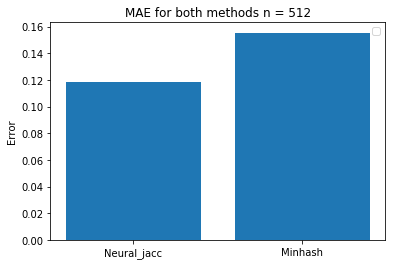

In [19]:
# plot simple bar chart of MSE
objects = ('Neural_jacc', 'Minhash')
y_pos = np.arange(len(objects))
mae_values = [mae_hash_jacc, mae_minhash]
 
p2 = plt.bar(y_pos, mae_values)
plt.xticks(y_pos, objects)
plt.ylabel('Error')
plt.title('MAE for both methods n = 512')
plt.legend()
plt.savefig('errors.png')
plt.show()